Train API


- 전체과정
    - [토큰화된 데이터] → [Dataset] → [Trainer 설정] → Trainer.train() → 모델 학습 완료

In [ ]:
# Train api
# pytorch 

In [2]:
# 전처리
from transformers import BertTokenizer
BERT_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_NAME)

In [3]:
# 데이터 준비
import nltk
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('movie_reviews')
ids = movie_reviews.fileids()  # fileid에 있는 하나 하나의 txt 리뷰들을 ids 리스트로 반환한다
reviews = [movie_reviews.raw(id) for id in ids]
categories = [movie_reviews.categories(id)[0] for id in ids]

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\SAMSUNG\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [ ]:
# 라벨인코딩
y = [1 if c == 'pos' else 0 for c in categories] # categories에 있는 하나의 c들을 꺼내서 pos면 1 아니면 0으로 변환해서 리스트를 만들어줘

In [9]:
# train, test 분할
x_train, x_test, y_train, y_test = train_test_split(reviews, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)

In [ ]:
# 데이터셋
import torch
from torch.utils.data import Dataset,DataLoader
class MovieReviewDataset(Dataset):
    '''
    Args
        encodings : 토큰나이저된 값(딕셔너리 형태)
        labels : 라벨링된 클래스 값( 0 1)
    '''
    def __init__(self,encodings, labels):   # __init__() = 데이터 저장
        self.encodings = encodings  # Dataset 객체 안에 tokenizer로 만들어진 입력 데이터를 저장
        self.labels = labels        # Dataset 객체 안에 문장별 라벨(정답) 저장
    def __getitem__(self, index):   # torch 데이터를 받는다 # __getitem__() = 인덱스별 샘플 반환 (tensor 형태, dict + label)
        item = {
            key:val[index].clone().detach() #  .clone() 새로운 복사본 생성  # gradient(미분) 계산을 하지 않는 텐서
            for key,val in self.encodings.items()
        }
        item['labels'] = torch.tensor(self.labels[index], dtype = torch.long)
        return item
    def __len__(self):
        return len(self.labels)
    
# 토큰화 (BertTokenizerFast) 
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(
    x_train,
    truncation = True,
    padding = True,
    max_length = 512,
    return_tensors = 'pt'
)
test_encodings = tokenizer(
    x_test,
    truncation = True,
    padding = True,
    max_length = 512,
    return_tensors = 'pt'
)
train_dataset = MovieReviewDataset(train_encodings, y_train)
test_dataset = MovieReviewDataset(test_encodings, y_test)

In [16]:
next(iter(train_dataset))

{'input_ids': tensor([  101,  7494,  2797,  4575,  1006,  3959,  9316,  1007,  2770,  2051,
          1024,  1016,  2847,  4466,  2781,  1012,  4626,  3419,  9180,  2015,
          1010,  3487,  7641,  1010,  3419,  2946,  5974,  1998,  4717, 11317,
          2856,  2011,  7112, 28740,  2525,  2108, 16586,  2004,  1996,  1005,
          4602,  2162,  3185,  2412,  2081,  1010,  1005,  7494,  2797,  4575,
          2003,  2019, 24560,  2075,  1010,  6517,  4181,  2075,  1998, 15544,
         19510,  2075,  3185,  1012,  2009,  2089,  2025,  2022,  1996,  4602,
          2162,  3185,  1999,  2026,  5448,  1010,  2021,  2009,  1005,  1055,
          5121,  2028,  1997,  1996,  2190,  2162,  5691,  2081,  1010,  1998,
          2028,  1997,  1996,  2190,  1997,  2687,  1012,  3419,  9180,  2015,
          3340,  2004,  1037,  2952,  2040,  1005,  1055, 10123,  2038,  2000,
          2424,  2797,  4575,  1006, 11317,  1007,  2040,  2038,  1037,  7281,
          2188,  2138,  2010,  2093,  3

---

<span style="color: Gold"> Trainer API
1) 사전학습된 BERT 모델 불러오기 (분류용, 라벨 수 지정)
2) 평가 지표(metric) 불러오기
3) 평가 함수 compute_metrics 정의
4) TrainingArguments → 학습 설정
5) Trainer → 학습 엔진 생성 (데이터셋 + 모델 + 설정 묶기)

In [ ]:
# Trainer API
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
import evaluate  # evaluate 허깅페이스 라이브러리 사용
# 모델 로드  클래스개수 2
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
# 평가지표 불러오기
accuracy_metric = evaluate.load('accuracy')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')
f1_metric = evaluate.load("f1")
# 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # metric 로드 -> 허깅 페이스의 평가 라이브러리를 통해 정확도, 정밀도, 재현율, f1을 자동으로 계산
    # 허깅페이스는 도구만 제공하고, 사용 방법은 우리가 결정하는 구조
    return { # compute 허깅페이스에서 직접 만드는 사용자 정의 함수
        'accuracy' : accuracy_metric.compute(predictions=predictions, references=labels)['accuracy'],
        'precision' : precision_metric.compute(predictions=predictions, references=labels)['precision'],
        'recall' : recall_metric.compute(predictions=predictions, references=labels)['recall'],
        'f1' : f1_metric.compute(predictions=predictions, references=labels)['f1'],
    }

# TraingAguments 학습설정 -> 학습 방법을 설정하는 설정서
# 몇 epoch 동안 학습할래? 배치사이즈는? 학습률은? 평가는 언제할래? 모델은 언제 저장할래 등을 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,             # NLP 에서는 2 ~5
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16, # 평가는 gradient 안하므로 train보다 크게설정하는 경향
    learning_rate=2e-5,     # 2e-5 는 BERT 표준 학습률
    weight_decay=0.01,  # L2정규화 규제 강도   # 가중치가 너무 커지지 않도록 조금씩 감소시키는 규제
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch',          # epoch 끝날 때마다 검증
    save_strategy='epoch',          # epoch 마다 모델 저장
    load_best_model_at_end=True,    # F1 제일 높은 모델 선택
    metric_for_best_model='f1',     # F1 스코어 기준으로 best 판단
    report_to='none'
)
# Trainer 객체 만들기 -> 그 설정서를 사용해서 실제 학습을 수행하는 기계(훈련 엔진)
# GPU 자동 감지됨
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics
)
# 학습실행
trainer.train()

코랩으로 돌린 결과

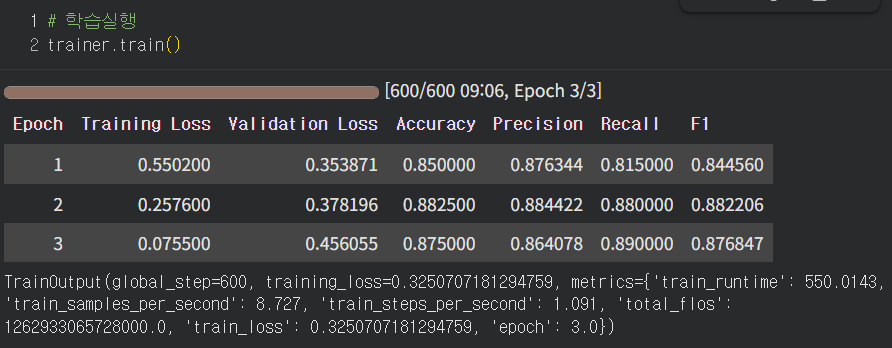

In [ ]:
reseults = trainer.evaluate()

---

<span style="color: Gold"> 직접 BERT 모델로 분류 작업 준비</span>   
-> 직접 헤드를 붙이면 커스터마이징이 가능

<span style="color: lightblue;"> Bert Model과 BertForSequenceClassification의 차이점

<span style="font-size:12px;">


| 구분                 | BertModel + 직접 분류 헤드                     | BertForSequenceClassification             |
|--------------------|----------------------------------------------|-----------------------------------------|
| 기본 모델           | BertModel (Transformer만 있음)               | BertModel + Linear 분류 헤드 포함       |
| CLS 토큰 활용       | CLS 임베딩 → 직접 Linear layer에 넣음        | CLS 임베딩 → 이미 붙은 Linear layer → logits |
| 출력                | Linear layer 거쳐 logits → Softmax 등 직접 구현 | logits → Softmax 등 바로 예측 가능      |
| 커스터마이징        | 자유롭게 Dropout, 초기화, 층 추가 가능       | 헤드 구조가 고정, 자유도 제한           |
| 학습/실험 용이성    | 연구, 임베딩 분석, 문장 유사도 등 실험 용도 좋음 | 바로 분류, 감성분석 등 일반적인 Task 용이 |

<span style="color: lightblue;"> <과정>
- BERT 사전학습 모델을 멤버로 저장  
- 분류기(선형층)를 만들어 BERT의 [CLS] 벡터 → 라벨 개수로 변환  
- 드롭아웃을 추가해 과적합 감소  
- 분류기 가중치와 편향을 초기화 (예: Xavier, zero)  
- forward에서는 BERT에 입력을 넣어 pooled output([CLS])을 얻고, 드롭아웃 → 선형 → 로짓 반환  
- (학습 시) CrossEntropyLoss로 로짓과 레이블의 손실을 계산  

In [ ]:
# Pytorch로 직접개선
# 메모리 정리
# del model , trainer
torch.cuda.empty_cache()


# BertForSequenceClassification  --> Bert전용모델
# 분류용 헤드를 포함 : [CLS]토큰을 출력 -> Linear layer -> logits

# BertModel : BERT 전용
# 분류헤드없음 -> 분류 회귀 QA등 작업에 바로 쓰려면 헤드를 붙여야한다.
from transformers import BertModel
import torch.nn.functional as F
from torch.optim import AdamW # BERT처럼 가중치가 많은 모델에 추천되는 optimizer. 학습률(lr)과 weight decay 설정
import time

# Bert모델
bert_model = BertModel.from_pretrained('bert-base-uncased')

class ImporovedBertClassifier(torch.nn.Module):
  """
개선된 BERT 분류기
  - Dropout 추가
  - 선형층 가중치 Xavier 초기화
입력:
  pretrained_model: transformers의 BertModel 또는 AutoModel (pooler_output이 있거나, 마지막 hidden state 사용)
  num_labels: 출력 클래스 수
  dropout: 드롭아웃 비율
출력:
  logits (batch_size, num_labels)
"""
  def __init__(self,pretrained_model, num_labels=2,dropout=0.1):
    super(ImporovedBertClassifier, self).__init__()
    self.bert = pretrained_model
    self.dropout = torch.nn.Dropout(dropout)
    self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)
    # BERT 분류기 가중치 초기화 - 선형계층 초기화(입력과 출력의 분산을 일정하게 유지)
    torch.nn.init.xavier_uniform_(self.classifier.weight)   # 분류기 가중치와 편향을 초기화한다 (예: Xavier, zero)
    # 편향 초기화
    torch.nn.init.zeros_(self.classifier.bias)
  def forward(self,input_ids,attention_mask, token_type_ids): # 순전파 forward
    outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )
    cls_output = outputs.last_hidden_state[ : , 0 , : ]
    cls_output =  self.dropout(cls_output)
    return self.classifier(cls_output)

#모델초기화
model = ImporovedBertClassifier(bert_model, num_labels=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# dataloader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

#옵티마이져 손실함수
optimizer = AdamW(model.parameters(),lr=2e-5, weight_decay=0.01)
# crossentropyloss는 softmax가 적용
criterion = torch.nn.CrossEntropyLoss() # CrossEntropyLoss 다중 클래스 분류용 손실함수. softmax + negative log likelihood 포함
num_epochs = 3
model.train()   # Dropout 등 레이어를 학습 모드로 전환
start = time.time()

# 학습루프
for epoch in range(num_epochs):
  total_loss = 0
  for step,batch in  enumerate(train_loader):
    optimizer.zero_grad()   # zero_grad 기울기 초기화. gradient 누적 방지
    #입력준비
    # 배치 안에 들어가 있는 것을 각 필요한 항목만 꺼냄
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)
    labels = batch['labels'].to(device)
    # forward (모델 예측)
    outputs = model(input_ids, attention_mask, token_type_ids)  # 입력 데이터를 모델에 넣어 logits 출력(숫자인 결과값)
    loss = criterion(outputs,labels)   

    #backward(역전파)
    loss.backward() # 손실을 기준으로 모든 가중치에 대한 gradient 계산
    optimizer.step()  # 계산된 gradient를 이용해 실제 모델 가중치를 업데이트
    total_loss += loss.item()
epoch_loss = total_loss / len(train_loader)
print(f'epoch : {epoch+1}  loss : {epoch_loss}')


<span style="color: lightblue;"> 배치형태 --> 입력준비 단계의 배치 형태  


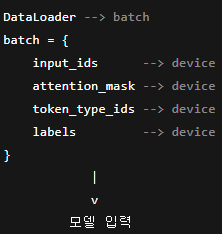

<span style="color: lightblue;"> BertForSequenceClassification 모델과 비교하여 어떤점이 개선되었는가?

<span style="font-size:12px;">

| 항목                | BertForSequenceClassification | 개선 코드 (imporvedBertClassifier)            |
|--------------------|-----------------------------|---------------------------------------------|
| Dropout            | 기본값만 있음               | 원하는 비율로 적용 가능                       |
| Linear layer 초기화 | 내부 초기화                 | Xavier 초기화 + 편향 0 초기화               |
| 구조 커스터마이징   | 불가                        | Linear 층 자유롭게 설계 가능                 |
| 학습 제어           | Trainer API 사용            | PyTorch 직접 옵티마이저/손실 함수 설정 가능  |
| 연구/실험 목적      | 제한적                      | CLS 임베딩 분석, 문장 유사도 등 활용 가능    |